In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from torch_geometric.data import Data
import torch_geometric
import networkx as nx


from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset as GNNDataset
from ClusterDatasetTransformer import ClusterDataset
from train_transformer import *
from data_statistics import *

from IPython.display import display

from Transformer import Transformer
from lang import Lang
from LossFunction import Loss

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
input_length = 60
max_seq_length = 60
batch_size = 8
converter = Lang(0)

In [4]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo_10pion0PU/"
data_folder_training = "/eos/user/c/czeh/graph_data/processed"
store_folder_training = "/eos/user/c/czeh/graph_data_trans"
data_folder_test = "/eos/user/c/czeh/graph_data_test/processed"
store_folder_test = "/eos/user/c/czeh/graph_data_trans_test"

# dataset_training = ClusterDataset(store_folder_training, data_folder_training, input_length=input_length)
dataset_test = ClusterDataset(store_folder_test, data_folder_test, input_length=input_length)

0


Processing...


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Done!


In [18]:
# train_dl = DataLoader(dataset_training, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=4)
test_dl = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [19]:
epochs = 100
d_model = 128
num_heads = 4
num_layers = 6
d_ff = 256
dropout = 0.2
padding = converter.word2index["<PAD>"]
feature_num = len(dataset_test.model_feature_keys)
max_nodes = max(dataset_test.max_nodes, dataset_test.max_nodes)
vocab_size = max_nodes + 4

# Model, loss, and optimizer
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
criterion = Loss(converter)

In [20]:
# Optionally introduce weight decay
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Drop Step Size over time
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [21]:
#Load Weights if needed
# weights = torch.load("/eos/user/c/czeh/tranformer_2.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

In [22]:
train_loss_hist = []
val_loss_hist = []

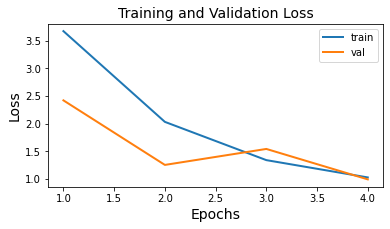

Epoch: 1


Training Epoch 1: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


Training loss: 3.6700041627883913


Validation Epoch 1: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]

Validation loss: 2.419086921215057


Epoch 2, LR: 0.0001
Epoch: 2


Training Epoch 2: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


Training loss: 2.0304535388946534


Validation Epoch 2: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

Validation loss: 1.2525973349809647


Epoch 3, LR: 0.0001
Epoch: 3


Training Epoch 3: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Training loss: 1.3391346526145935


Validation Epoch 3: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]

Validation loss: 0.9520336046814919


Epoch 4, LR: 0.0001
Epoch: 4


Training Epoch 4: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Training loss: 1.026372528076172


Validation Epoch 4: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]

Validation loss: 0.7686709325015545


Epoch 5, LR: 0.0001
Epoch: 5


Training Epoch 5:  18%|█▊        | 9/50 [00:03<00:16,  2.44it/s]


KeyboardInterrupt: 

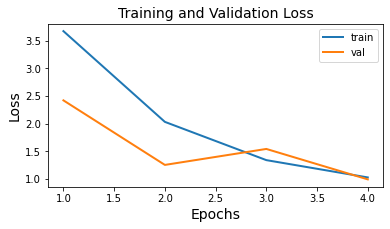

In [23]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
# Optionally introduce gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25)

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

display_loss = display(1, display_id=True)

optimizer.zero_grad()

# Training loop
for epoch in range(1, 101):
    print(f'Epoch: {epoch}')
    
    loss = train(model, optimizer, test_dl, epoch, criterion, vocab_size, device=device)
    print(f"Training loss: {loss}")
    train_loss_hist.append(loss)
    
    val_loss = test(model, test_dl, epoch, criterion, vocab_size, device=device)
    val_loss_hist.append(val_loss)
    print(f"Validation loss: {val_loss}")
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss, n=1)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    scheduler.step()
    print(f"Epoch {epoch+1}, LR: {scheduler.get_last_lr()[0]}")

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
epochs = len(train_loss_hist)
ax.plot(range(1, epochs+1), moving_average(train_loss_hist, 8), label='train', linewidth=2)
ax.plot(range(1, epochs+1), moving_average(val_loss_hist, 8), label='val', linewidth=2)
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)
ax.set_title("Training and Validation Loss", fontsize=14)
ax.legend()

In [ ]:
date = f"{datetime.now():%Y-%m-%d}"
save_model(model, epoch, optimizer, train_loss_hist, val_loss_hist, model_folder, f"tranformer_date_{date}.pt")

## Test Full Event

In [ ]:
from EventGrouping import EventGrouping

In [ ]:
model2 = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
weights = torch.load("/eos/user/c/czeh/tranformer_4.pt", weights_only=True)
model2.load_state_dict(weights["model_state_dict"])

In [ ]:
runner = EventGrouping(converter, model2, neighborhood=1, seq_length=input_length)
runner(dataset_test.get(0))

In [ ]:
model_feature_keys = np.array([0,  2,  3,  4,  6,  7, 10, 14, 15, 16, 17, 18, 22, 24, 25, 26, 28, 29])
dataset_training.__getitem__(0)[0][:, model_feature_keys][:, -1]

In [ ]:
dataset_test.get(0).cluster

In [ ]:
dataset_training.node_feature_keys[16]

In [ ]:
G = torch_geometric.utils.to_networkx(dataset_test.get(0), to_undirected=True)

In [ ]:
dataset_training.get(0).x[:, 16]

In [ ]:
fig, ax = plt.subplots(1, 1)
nx.draw(G, with_labels=True, ax=ax)

## Random Tests

In [ ]:
targets = dataset_training.__getitem__(0)[2]
mask = targets != -4
mask.unsqueeze(-1)

In [ ]:
targets[targets[:, -1] != -4, :]

In [ ]:
targets[mask].shape[0]/3

In [ ]:
opts = dataset_training.__getitem__(0)[1]
opts = torch.roll(opts, -1, dims=0)
opts[-1] = 5
opts

In [ ]:
out_mask = opts != -4
opts[out_mask].shape[0]

In [ ]:
targets = torch.reshape(targets[mask], (int(targets[mask].shape[0]/3), 3))

In [ ]:
targets[0, :]